In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

In [6]:
!unzip VLASTITEDATASET.zip

Archive:  VLASTITEDATASET.zip
replace VLASTITEDATASET/1slika/slika3.1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
base_path = '/content/VLASTITEDATASET'

folder1 = os.path.join(base_path, '1slika')
folder2 = os.path.join(base_path, '2slika')
output_final = os.path.join(base_path, 'Rezultati_vlastitiDATA')

if not os.path.exists(output_final):
    os.makedirs(output_final)
    print(f"Kreirana mapa: {output_final}")

In [8]:
def get_laplacian_map(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F, ksize=3)
    return cv2.GaussianBlur(np.absolute(lap), (15, 15), 0)

def get_tenengrad_map(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    tenengrad = np.sqrt(sobelx**2 + sobely**2)
    return cv2.GaussianBlur(tenengrad, (15, 15), 0)

def izracunaj_varijancu_ostrinu(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def align_images(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(10000)
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = sorted(matcher.match(des1, des2, None), key=lambda x: x.distance)
    good_matches = matches[:int(len(matches) * 0.15)]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    h, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)

    return cv2.warpPerspective(img2, h, (img1.shape[1], img1.shape[0]))

In [9]:
slike1 = sorted([f for f in os.listdir(folder1) if f.endswith(('.jpg', '.jpeg', '.png'))])
slike2 = sorted([f for f in os.listdir(folder2) if f.endswith(('.jpg', '.jpeg', '.png'))])

tablica_podaci = []

for file1, file2 in zip(slike1, slike2):
    img1 = cv2.imread(os.path.join(folder1, file1))
    img2 = cv2.imread(os.path.join(folder2, file2))

    if img1 is not None and img2 is not None:
        img2 = align_images(img1, img2)

        fm1 = get_laplacian_map(img1)
        fm2 = get_laplacian_map(img2)

        mask = (fm1 > fm2).astype(np.float32)
        soft_mask = cv2.GaussianBlur(mask, (31, 31), 0)
        soft_mask_3d = cv2.merge([soft_mask, soft_mask, soft_mask])

        output = (img1.astype(np.float32) * soft_mask_3d +
                  img2.astype(np.float32) * (1.0 - soft_mask_3d)).astype(np.uint8)

        v1 = izracunaj_varijancu_ostrinu(img1)
        v2 = izracunaj_varijancu_ostrinu(img2)
        v_out = izracunaj_varijancu_ostrinu(output)

        tablica_podaci.append((file1, v1, v2, v_out))

        cv2.imwrite(os.path.join(output_final, f'stacked_{file1}'), output)

print(f"{'Slika':<15} | {'Var A':<10} | {'Var B':<10} | {'Var Final':<10}")
for ime, va, vb, vout in tablica_podaci[:5]:
    print(f"{ime:<15} | {va:<10.2f} | {vb:<10.2f} | {vout:<10.2f}")

Slika           | Var A      | Var B      | Var Final 
slika3.1.jpeg   | 3.88       | 10.16      | 11.27     
slika4.1.jpeg   | 19.60      | 87.22      | 94.03     
slika5.1.jpeg   | 19.05      | 32.51      | 43.57     
slika6.1.jpeg   | 37.36      | 25.76      | 56.21     


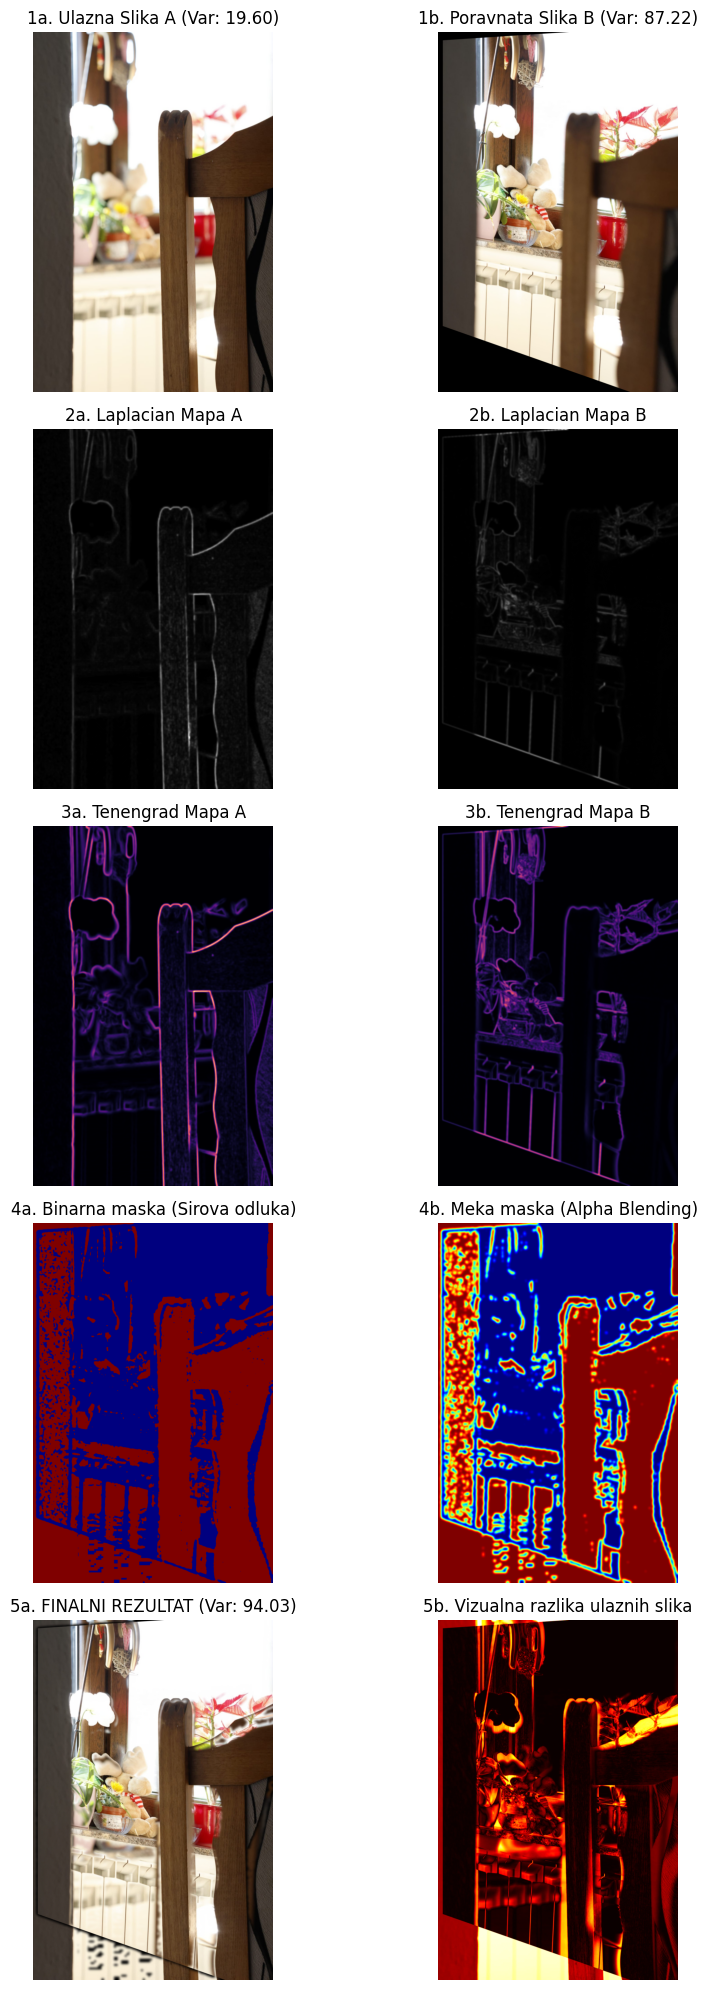

In [10]:
base_path = '/content/VLASTITEDATASET'

img1 = cv2.imread(os.path.join(base_path, '1slika', 'slika4.1.jpeg'))
img2 = cv2.imread(os.path.join(base_path, '2slika', 'slika4.2.jpeg'))

img2 = align_images(img1, img2)

fm1 = get_laplacian_map(img1)
fm2 = get_laplacian_map(img2)
fm1_ten = get_tenengrad_map(img1)
fm2_ten = get_tenengrad_map(img2)

mask = (fm1 > fm2).astype(np.float32)
soft_mask = cv2.GaussianBlur(mask, (31, 31), 0)
soft_mask_3d = cv2.merge([soft_mask, soft_mask, soft_mask])

output_f = img1.astype(np.float32) * soft_mask_3d + img2.astype(np.float32) * (1.0 - soft_mask_3d)
output = output_f.astype(np.uint8)

v1 = izracunaj_varijancu_ostrinu(img1)
v2 = izracunaj_varijancu_ostrinu(img2)
v_out = izracunaj_varijancu_ostrinu(output)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

axes[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"1a. Ulazna Slika A (Var: {v1:.2f})")
axes[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f"1b. Poravnata Slika B (Var: {v2:.2f})")

axes[1, 0].imshow(fm1, cmap='gray')
axes[1, 0].set_title("2a. Laplacian Mapa A")
axes[1, 1].imshow(fm2, cmap='gray')
axes[1, 1].set_title("2b. Laplacian Mapa B")

axes[2, 0].imshow(fm1_ten, cmap='magma')
axes[2, 0].set_title("3a. Tenengrad Mapa A")
axes[2, 1].imshow(fm2_ten, cmap='magma')
axes[2, 1].set_title("3b. Tenengrad Mapa B")

axes[3, 0].imshow(mask, cmap='jet')
axes[3, 0].set_title("4a. Binarna maska (Sirova odluka)")
axes[3, 1].imshow(soft_mask, cmap='jet')
axes[3, 1].set_title("4b. Meka maska (Alpha Blending)")

axes[4, 0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[4, 0].set_title(f"5a. FINALNI REZULTAT (Var: {v_out:.2f})")

diff = cv2.absdiff(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))
axes[4, 1].imshow(diff, cmap='hot')
axes[4, 1].set_title("5b. Vizualna razlika ulaznih slika")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

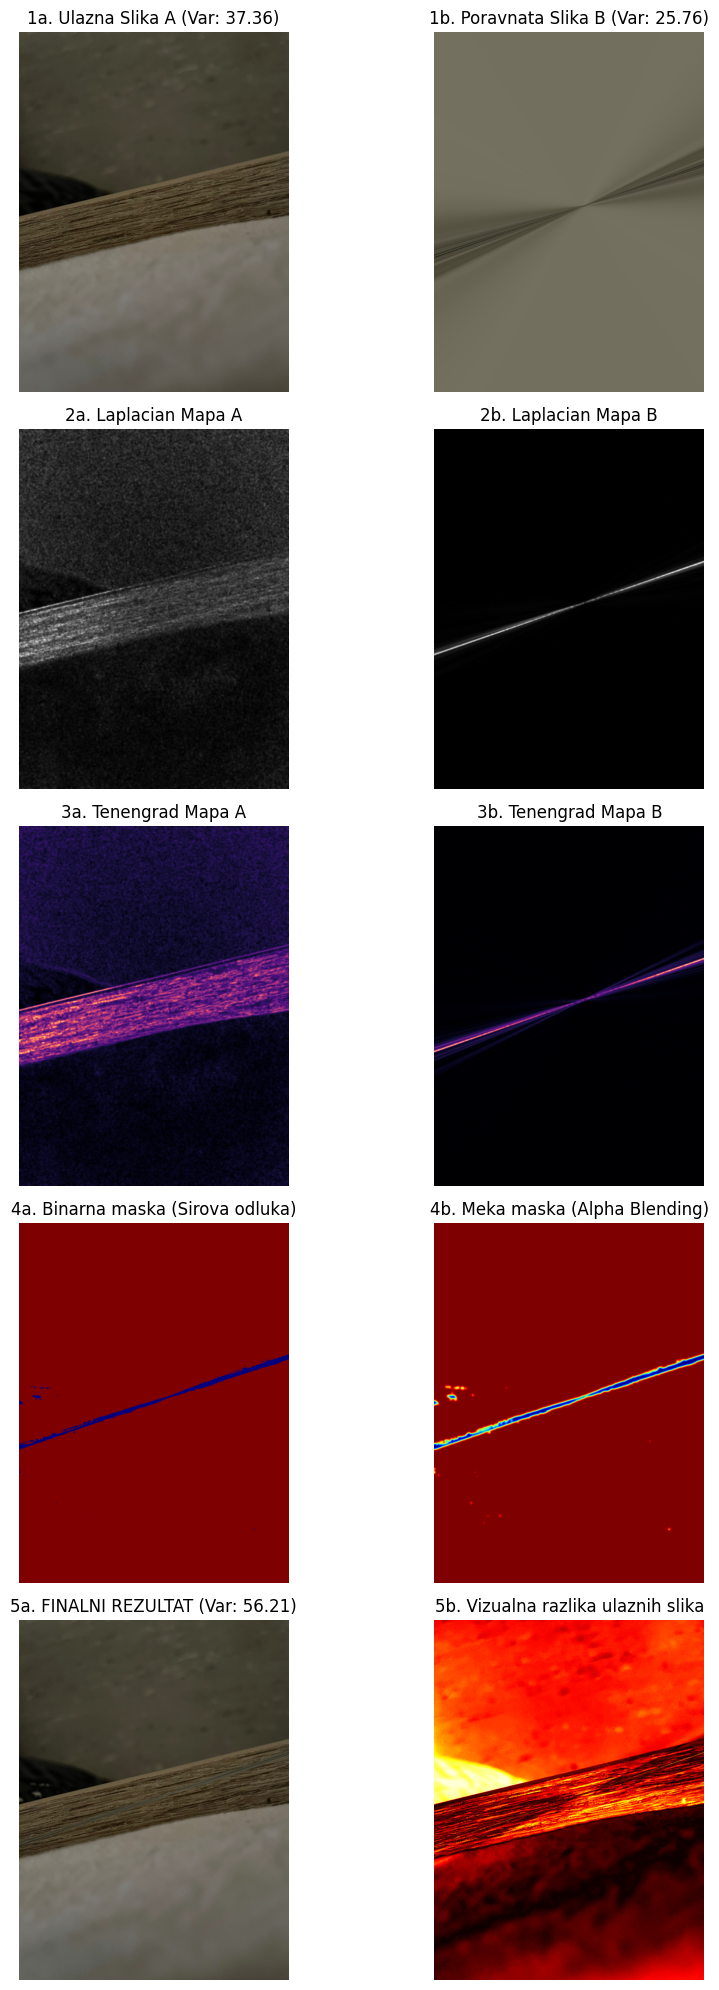

In [11]:
base_path = '/content/VLASTITEDATASET'

img1 = cv2.imread(os.path.join(base_path, '1slika', 'slika6.1.jpeg'))
img2 = cv2.imread(os.path.join(base_path, '2slika', 'slika6.2.jpeg'))

img2 = align_images(img1, img2)

fm1 = get_laplacian_map(img1)
fm2 = get_laplacian_map(img2)
fm1_ten = get_tenengrad_map(img1)
fm2_ten = get_tenengrad_map(img2)

mask = (fm1 > fm2).astype(np.float32)
soft_mask = cv2.GaussianBlur(mask, (31, 31), 0)
soft_mask_3d = cv2.merge([soft_mask, soft_mask, soft_mask])

output_f = img1.astype(np.float32) * soft_mask_3d + img2.astype(np.float32) * (1.0 - soft_mask_3d)
output = output_f.astype(np.uint8)

v1 = izracunaj_varijancu_ostrinu(img1)
v2 = izracunaj_varijancu_ostrinu(img2)
v_out = izracunaj_varijancu_ostrinu(output)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

axes[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"1a. Ulazna Slika A (Var: {v1:.2f})")
axes[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f"1b. Poravnata Slika B (Var: {v2:.2f})")

axes[1, 0].imshow(fm1, cmap='gray')
axes[1, 0].set_title("2a. Laplacian Mapa A")
axes[1, 1].imshow(fm2, cmap='gray')
axes[1, 1].set_title("2b. Laplacian Mapa B")

axes[2, 0].imshow(fm1_ten, cmap='magma')
axes[2, 0].set_title("3a. Tenengrad Mapa A")
axes[2, 1].imshow(fm2_ten, cmap='magma')
axes[2, 1].set_title("3b. Tenengrad Mapa B")

axes[3, 0].imshow(mask, cmap='jet')
axes[3, 0].set_title("4a. Binarna maska (Sirova odluka)")
axes[3, 1].imshow(soft_mask, cmap='jet')
axes[3, 1].set_title("4b. Meka maska (Alpha Blending)")

axes[4, 0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[4, 0].set_title(f"5a. FINALNI REZULTAT (Var: {v_out:.2f})")

diff = cv2.absdiff(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))
axes[4, 1].imshow(diff, cmap='hot')
axes[4, 1].set_title("5b. Vizualna razlika ulaznih slika")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

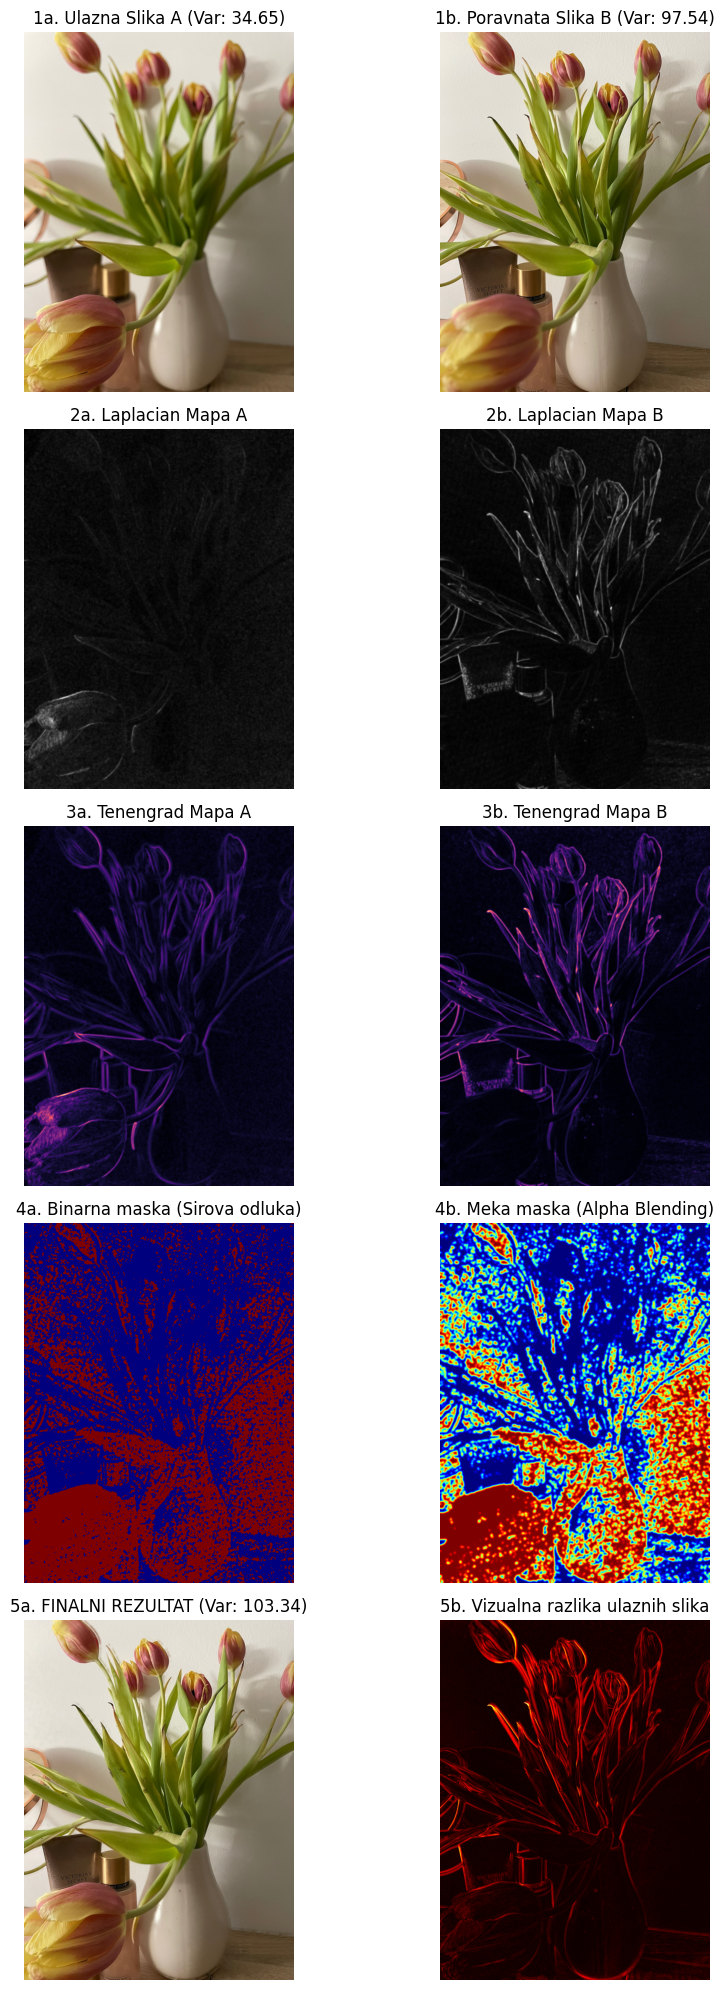

In [13]:
base_path = '/content/VLASTITEDATASET'

img1 = cv2.imread(os.path.join(base_path, '1slika', 'slika8.1.jpeg'))
img2 = cv2.imread(os.path.join(base_path, '2slika', 'slika8.2.jpeg'))

img2 = align_images(img1, img2)

fm1 = get_laplacian_map(img1)
fm2 = get_laplacian_map(img2)
fm1_ten = get_tenengrad_map(img1)
fm2_ten = get_tenengrad_map(img2)

mask = (fm1 > fm2).astype(np.float32)
soft_mask = cv2.GaussianBlur(mask, (31, 31), 0)
soft_mask_3d = cv2.merge([soft_mask, soft_mask, soft_mask])

output_f = img1.astype(np.float32) * soft_mask_3d + img2.astype(np.float32) * (1.0 - soft_mask_3d)
output = output_f.astype(np.uint8)

v1 = izracunaj_varijancu_ostrinu(img1)
v2 = izracunaj_varijancu_ostrinu(img2)
v_out = izracunaj_varijancu_ostrinu(output)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

axes[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"1a. Ulazna Slika A (Var: {v1:.2f})")
axes[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f"1b. Poravnata Slika B (Var: {v2:.2f})")

axes[1, 0].imshow(fm1, cmap='gray')
axes[1, 0].set_title("2a. Laplacian Mapa A")
axes[1, 1].imshow(fm2, cmap='gray')
axes[1, 1].set_title("2b. Laplacian Mapa B")

axes[2, 0].imshow(fm1_ten, cmap='magma')
axes[2, 0].set_title("3a. Tenengrad Mapa A")
axes[2, 1].imshow(fm2_ten, cmap='magma')
axes[2, 1].set_title("3b. Tenengrad Mapa B")

axes[3, 0].imshow(mask, cmap='jet')
axes[3, 0].set_title("4a. Binarna maska (Sirova odluka)")
axes[3, 1].imshow(soft_mask, cmap='jet')
axes[3, 1].set_title("4b. Meka maska (Alpha Blending)")

axes[4, 0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[4, 0].set_title(f"5a. FINALNI REZULTAT (Var: {v_out:.2f})")

diff = cv2.absdiff(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))
axes[4, 1].imshow(diff, cmap='hot')
axes[4, 1].set_title("5b. Vizualna razlika ulaznih slika")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

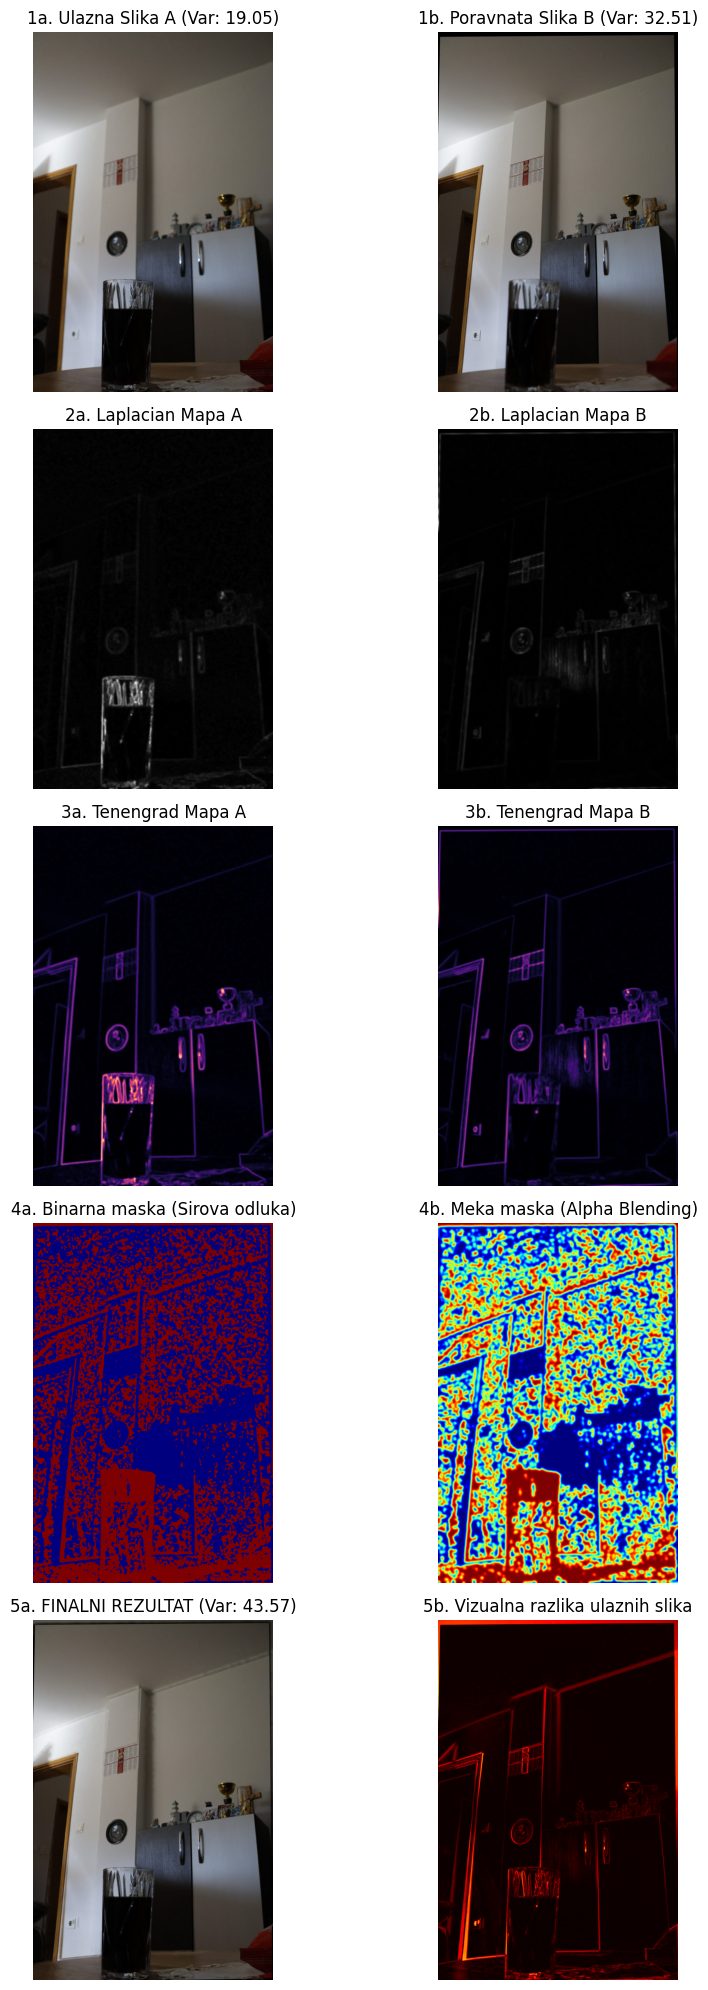

In [14]:
base_path = '/content/VLASTITEDATASET'

img1 = cv2.imread(os.path.join(base_path, '1slika', 'slika5.1.jpeg'))
img2 = cv2.imread(os.path.join(base_path, '2slika', 'slika5.2.jpeg'))

img2 = align_images(img1, img2)

fm1 = get_laplacian_map(img1)
fm2 = get_laplacian_map(img2)
fm1_ten = get_tenengrad_map(img1)
fm2_ten = get_tenengrad_map(img2)

mask = (fm1 > fm2).astype(np.float32)
soft_mask = cv2.GaussianBlur(mask, (31, 31), 0)
soft_mask_3d = cv2.merge([soft_mask, soft_mask, soft_mask])

output_f = img1.astype(np.float32) * soft_mask_3d + img2.astype(np.float32) * (1.0 - soft_mask_3d)
output = output_f.astype(np.uint8)

v1 = izracunaj_varijancu_ostrinu(img1)
v2 = izracunaj_varijancu_ostrinu(img2)
v_out = izracunaj_varijancu_ostrinu(output)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))

axes[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"1a. Ulazna Slika A (Var: {v1:.2f})")
axes[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f"1b. Poravnata Slika B (Var: {v2:.2f})")

axes[1, 0].imshow(fm1, cmap='gray')
axes[1, 0].set_title("2a. Laplacian Mapa A")
axes[1, 1].imshow(fm2, cmap='gray')
axes[1, 1].set_title("2b. Laplacian Mapa B")

axes[2, 0].imshow(fm1_ten, cmap='magma')
axes[2, 0].set_title("3a. Tenengrad Mapa A")
axes[2, 1].imshow(fm2_ten, cmap='magma')
axes[2, 1].set_title("3b. Tenengrad Mapa B")

axes[3, 0].imshow(mask, cmap='jet')
axes[3, 0].set_title("4a. Binarna maska (Sirova odluka)")
axes[3, 1].imshow(soft_mask, cmap='jet')
axes[3, 1].set_title("4b. Meka maska (Alpha Blending)")

axes[4, 0].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[4, 0].set_title(f"5a. FINALNI REZULTAT (Var: {v_out:.2f})")

diff = cv2.absdiff(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))
axes[4, 1].imshow(diff, cmap='hot')
axes[4, 1].set_title("5b. Vizualna razlika ulaznih slika")

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

VGG

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


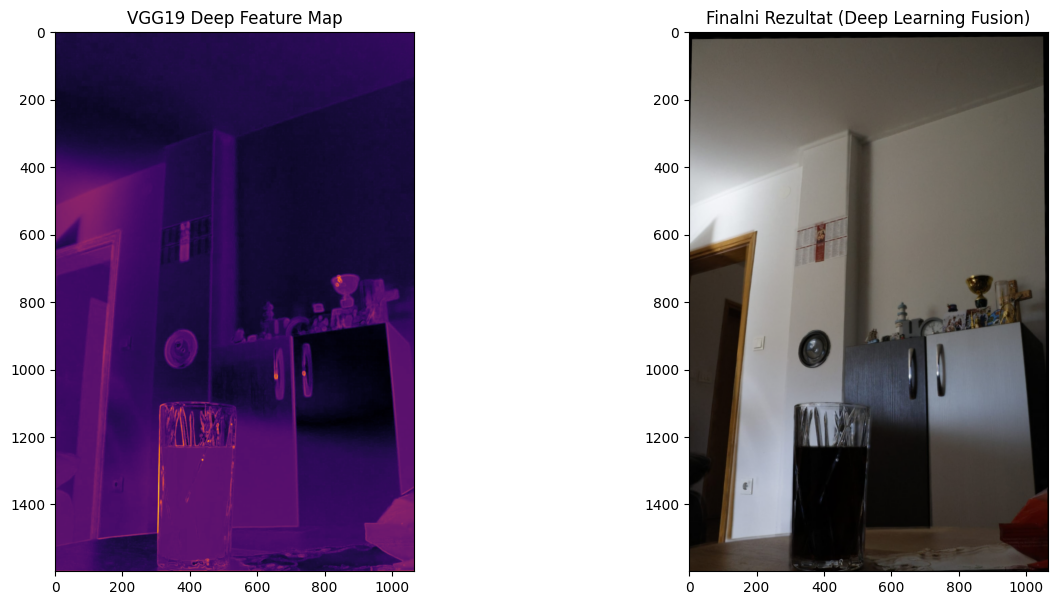

Oštrina (Varijanca) AI rezultata: 31.50


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

def vgg_fusion_feature_map(img1, img2):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(None, None, 3))

    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv2').output)

    def prepare(img):
        img_f = img.astype(np.float32)
        img_f = np.expand_dims(img_f, axis=0)
        return tf.keras.applications.vgg19.preprocess_input(img_f)

    feat1 = model.predict(prepare(img1), verbose=0)
    feat2 = model.predict(prepare(img2), verbose=0)

    map1 = np.sum(feat1[0], axis=-1)
    map2 = np.sum(feat2[0], axis=-1)

    map1_res = cv2.resize(map1, (img1.shape[1], img1.shape[0]))
    map2_res = cv2.resize(map2, (img1.shape[1], img1.shape[0]))

    mask_ai = (map1_res > map2_res).astype(np.float32)
    soft_mask_ai = cv2.GaussianBlur(mask_ai, (31, 31), 0)
    soft_mask_3d = cv2.merge([soft_mask_ai, soft_mask_ai, soft_mask_ai])

    output_ai = (img1.astype(np.float32) * soft_mask_3d +
                 img2.astype(np.float32) * (1.0 - soft_mask_3d)).astype(np.uint8)

    return output_ai, map1_res, map2_res

out_deep, m1_deep, m2_deep = vgg_fusion_feature_map(img1, img2)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(m1_deep, cmap='inferno')
axes[0].set_title("VGG19 Deep Feature Map")
axes[1].imshow(cv2.cvtColor(out_deep, cv2.COLOR_BGR2RGB))
axes[1].set_title("Finalni Rezultat (Deep Learning Fusion)")
plt.show()

print(f"Oštrina (Varijanca) AI rezultata: {izracunaj_varijancu_ostrinu(out_deep):.2f}")

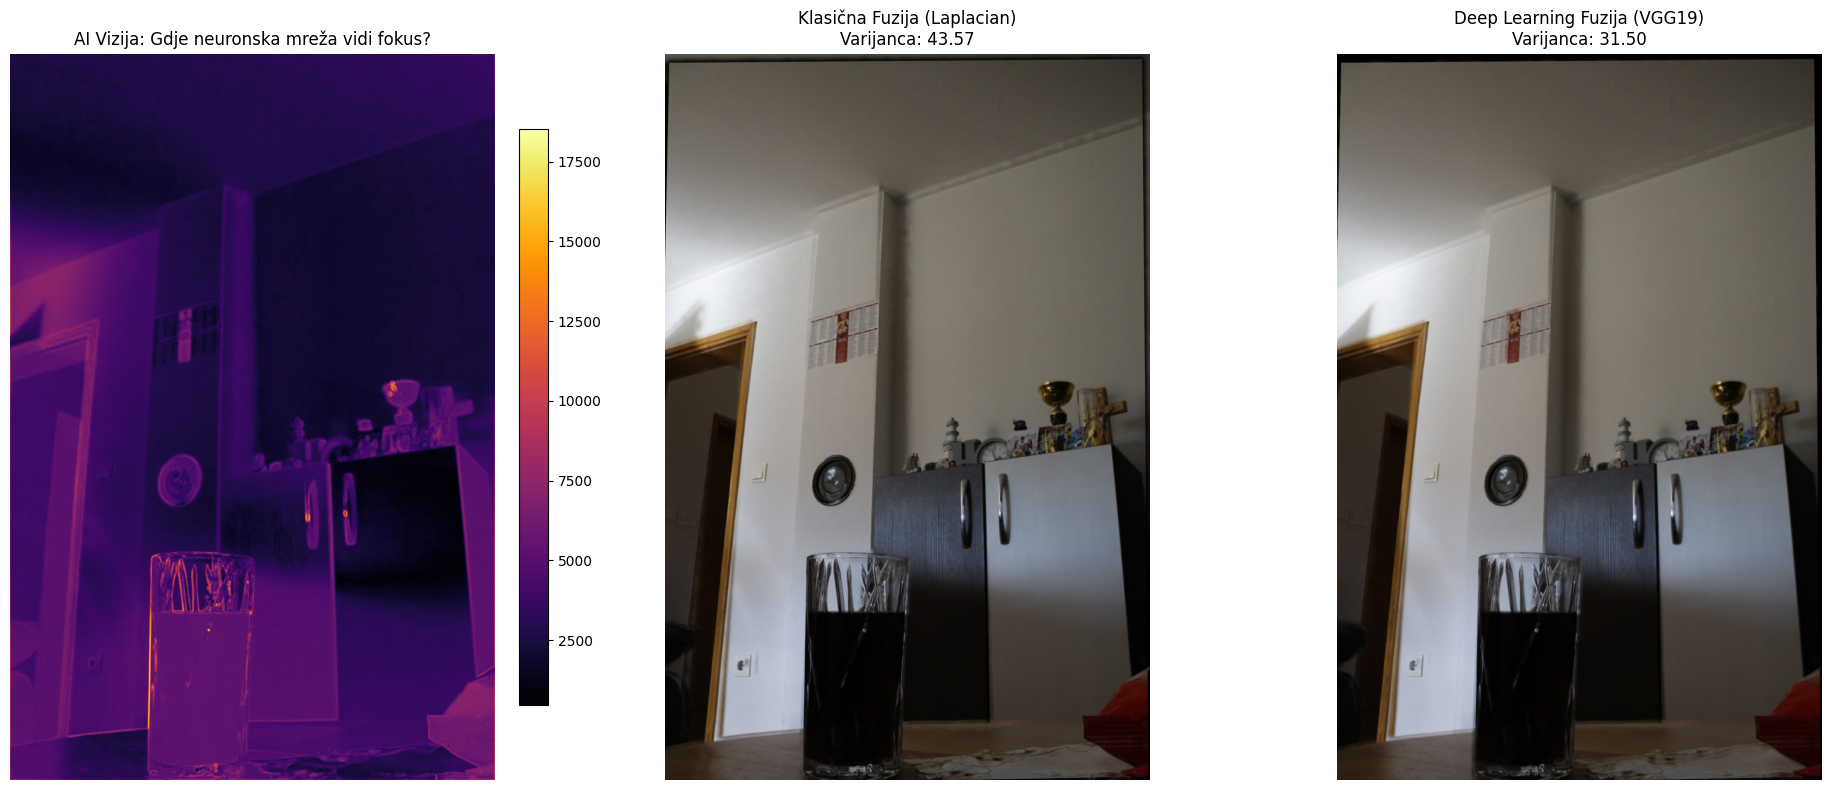

Razlika u oštrini: 12.07


In [16]:
fm1_lap = get_laplacian_map(img1)
fm2_lap = get_laplacian_map(img2)
mask_lap = (fm1_lap > fm2_lap).astype(np.float32)
soft_lap = cv2.GaussianBlur(mask_lap, (31, 31), 0)
soft_lap_3d = cv2.merge([soft_lap, soft_lap, soft_lap])
out_lap = (img1.astype(np.float32) * soft_lap_3d + img2.astype(np.float32) * (1.0 - soft_lap_3d)).astype(np.uint8)

out_ai, map1_ai, _ = vgg_fusion_feature_map(img1, img2)

v_lap = izracunaj_varijancu_ostrinu(out_lap)
v_ai = izracunaj_varijancu_ostrinu(out_ai)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

im0 = axes[0].imshow(map1_ai, cmap='inferno')
axes[0].set_title("AI Vizija: Gdje neuronska mreža vidi fokus?")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(cv2.cvtColor(out_lap, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Klasična Fuzija (Laplacian)\nVarijanca: {v_lap:.2f}")

axes[2].imshow(cv2.cvtColor(out_ai, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"Deep Learning Fuzija (VGG19)\nVarijanca: {v_ai:.2f}")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Razlika u oštrini: {abs(v_ai - v_lap):.2f}")